<a
href="https://colab.research.google.com/github/KyuyeolShin/dic/blob/main/DIC_Project1.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
from scipy import stats

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, UpSampling1D

# 데이터 생성

In [3]:
#!wget "https://github.com/KyuyeolShin/dic/raw/main/svc.zip"

In [4]:
#!unzip -P 암호입력 svc.zip

In [5]:
warnings.filterwarnings('ignore')

In [6]:
svc_data = pd.read_csv("svc.csv", encoding='ms949')
print(svc_data.columns)
svc_data.head()

Index(['년도', '날짜', '요일', 'Sales', 'Daily SVC', 'Acc SVC', 'SVC 접수', '평균기온',
       '최고기온'],
      dtype='object')


년도      날짜   요일  Sales  Daily SVC  Acc SVC  SVC 접수  평균기온  최고기온
0  2016년  04월01일  금요일  54330          3      101       1  13.2  22.8
1  2016년  04월02일  토요일  55556          2      103       2  13.9  21.5
2  2016년  04월03일  일요일  55653          0      103       0  11.7  15.2
3  2016년  04월04일  월요일  56482          1      104       2  11.2  15.6
4  2016년  04월05일  화요일  57507          2      106       0  12.0  19.6

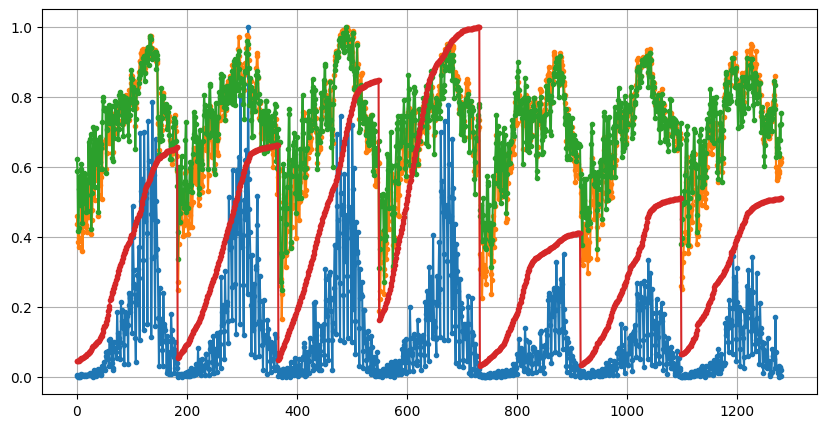

In [7]:
fig = plt.figure(figsize=(10,5))
plt.grid()
tmp = svc_data["SVC 접수"]/svc_data["SVC 접수"].max()
plt.plot(tmp,'.-')
tmp = svc_data["평균기온"]/svc_data["평균기온"].max()
plt.plot(tmp,'.-')
tmp = svc_data["최고기온"]/svc_data["최고기온"].max()
plt.plot(tmp,'.-')
tmp = svc_data["Sales"]/svc_data["Sales"].max()
plt.plot(tmp,'.-')

In [8]:
print(svc_data["날짜"].unique())
print(svc_data["요일"].unique())

['04월01일' '04월02일' '04월03일' '04월04일' '04월05일' '04월06일' '04월07일' '04월08일'
 '04월09일' '04월10일' '04월11일' '04월12일' '04월13일' '04월14일' '04월15일' '04월16일'
 '04월17일' '04월18일' '04월19일' '04월20일' '04월21일' '04월22일' '04월23일' '04월24일'
 '04월25일' '04월26일' '04월27일' '04월28일' '04월29일' '04월30일' '05월01일' '05월02일'
 '05월03일' '05월04일' '05월05일' '05월06일' '05월07일' '05월08일' '05월09일' '05월10일'
 '05월11일' '05월12일' '05월13일' '05월14일' '05월15일' '05월16일' '05월17일' '05월18일'
 '05월19일' '05월20일' '05월21일' '05월22일' '05월23일' '05월24일' '05월25일' '05월26일'
 '05월27일' '05월28일' '05월29일' '05월30일' '05월31일' '06월01일' '06월02일' '06월03일'
 '06월04일' '06월05일' '06월06일' '06월07일' '06월08일' '06월09일' '06월10일' '06월11일'
 '06월12일' '06월13일' '06월14일' '06월15일' '06월16일' '06월17일' '06월18일' '06월19일'
 '06월20일' '06월21일' '06월22일' '06월23일' '06월24일' '06월25일' '06월26일' '06월27일'
 '06월28일' '06월29일' '06월30일' '07월01일' '07월02일' '07월03일' '07월04일' '07월05일'
 '07월06일' '07월07일' '07월08일' '07월09일' '07월10일' '07월11일' '07월12일' '07월13일'
 '07월14일' '07월15일' '07월16일' '07월17일' '07월18일' '07월1

In [9]:
#데이터 전처리
def PreProcess(input_data):
    ret_data = input_data
    month = ["04월", "05월", "06월", "07월", "08월", "09월"]
    day = ["01일", "02일", "03일", "04일", "05일", "06일", "07일", "08일", "09일", "10일", 
           "11일", "12일", "13일", "14일", "15일", "16일", "17일", "18일", "19일", "20일", 
           "21일", "22일", "23일", "24일", "25일", "26일", "27일", "28일", "29일", "30일", "31일"]
    week = ['일요일', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일']
    nYear = 1;
    nWeek = 1;
    
    for m in month: #4월1일->4.01로 변경
        for d in day:
            nMonth = int(re.sub(r'[^0-9]', '', m))
            nDay = int(re.sub(r'[^0-9]', '', d))
            date = m+d
            cond = ret_data["날짜"] == date
            ret_data["날짜"][cond] = nMonth+(nDay/100)
    for w in week:
        cond = ret_data["요일"] == w
        ret_data["요일"][cond] = nWeek
        nWeek = nWeek+1
        
    return ret_data

In [10]:
svc_data = PreProcess(svc_data)

In [11]:
svc_data.info()
svc_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281 entries, 0 to 1280
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   년도         1281 non-null   object 
 1   날짜         1281 non-null   object 
 2   요일         1281 non-null   object 
 3   Sales      1281 non-null   int64  
 4   Daily SVC  1281 non-null   int64  
 5   Acc SVC    1281 non-null   int64  
 6   SVC 접수     1281 non-null   int64  
 7   평균기온       1281 non-null   float64
 8   최고기온       1281 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 90.2+ KB


년도    날짜 요일  Sales  Daily SVC  Acc SVC  SVC 접수  평균기온  최고기온
0  2016년  4.01  6  54330          3      101       1  13.2  22.8
1  2016년  4.02  7  55556          2      103       2  13.9  21.5
2  2016년  4.03  1  55653          0      103       0  11.7  15.2
3  2016년  4.04  2  56482          1      104       2  11.2  15.6
4  2016년  4.05  3  57507          2      106       0  12.0  19.6

In [12]:
def GetTrainData(data, nTimes, nPred=1):
    x = []
    y = []
    x_col_ol = ["평균기온", "최고기온", "Sales", "SVC 접수"]
    x_col_sg = ["날짜", "요일"]
    y_col = ["SVC 접수"]
    if nPred == 0:
        print("예측데이터 수 에러")
        return x, y
    if nTimes <= 1:
        x = np.array(data[x_col]).tolist()
        y = np.array(adata[y_col]).tolist()
    else:
        for i in range(data.shape[0]):
            if (i+nPred) > data.shape[0]:
                break
            if i < nTimes:
                continue
            else:
                x_arr = np.array([])
                for j in x_col_ol:
                    x_arr = np.concatenate((x_arr, data[j][i-nTimes:i]))
                tmp = data[x_col_sg].loc[i-1]
                x_list = list(np.concatenate((tmp, x_arr), axis=0))
                x.append(x_list)
                tmp = data["SVC 접수"][i:i+nPred]
                y.append(list(tmp))
    return x, y

In [13]:
#연도별 overlap 데이터 생성
pred_day = 1
times = 3*pred_day
year = svc_data["년도"].unique()
year = year[0:-1] # 2021년까지
x_data = []
y_data = []
for i in year:
    print(i)
    cond = svc_data["년도"] == i
    x_tmp, y_tmp = GetTrainData(svc_data[cond].reset_index(), times, pred_day)
    x_data = x_data+x_tmp
    y_data = y_data+y_tmp

2016년
2017년
2018년
2019년
2020년
2021년


In [14]:
np.shape(x_data)

(1080, 14)

In [15]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x_data)
y = np.array(y_data)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.3, random_state = 1)

In [17]:
x_row, x_col = np.shape(x_train)
y_row, y_col = np.shape(y_train)
print(x_row, x_col, y_row, y_col)

864 14 864 1


# 데이터 학습

In [18]:
# 학습 = 0, 학습된 파라미터 Load = 1
load_model_nn = 1
load_model_cnn = 1
load_model_lstm = 1
load_model_bagging = 1
load_model_cnn_2d = 1

In [19]:
#Dense
model_nn = Sequential()
model_nn.add(Dense(units=128, activation='relu', input_dim=x_col))
model_nn.add(Dense(units=256, activation='relu'))
model_nn.add(Dense(units=y_col, activation='relu'))
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 35201 (137.50 KB)
Trainable params: 35201 (137.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
if load_model_nn == True:
    model_nn.load_weights('svc_model_nn.h5')
else:
    model_nn.compile(loss='mse', optimizer='adam', metrics=['mse'])
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
    history = model_nn.fit(x_train, y_train, 
        epochs=2000, 
        batch_size=32, 
        callbacks=[early_stopping], 
        validation_data=(x_val, y_val), 
        verbose=2)
    if early_stopping.stopped_epoch > 0:
        stopped_loss = history.history['loss'][early_stopping.stopped_epoch - 1]
        print("Early stopping stopped at epoch", early_stopping.stopped_epoch, "with loss", stopped_loss)

In [21]:
if load_model_nn == False:
    model_nn.save_weights('svc_model_nn.h5')

In [22]:
# 1D CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(x_col, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
model_cnn.add(Flatten())
model_cnn.add(Dense(units=128, activation='relu'))
model_cnn.add(Dense(y_col, activation='relu'))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 64)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 16)             1552      
                                                                 
 flatten (Flatten)           (None, 48)               

In [23]:
if load_model_cnn == True:
    model_cnn.load_weights('svc_model_cnn.h5')
else:
    model_cnn.compile(loss='mse', optimizer='adam', metrics=['mse'])
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
    history = model_cnn.fit(x_train, y_train, 
        epochs=2000, 
        batch_size=32, 
        callbacks=[early_stopping], 
        validation_data=(x_val, y_val), 
        verbose=2)
    if early_stopping.stopped_epoch > 0:
        stopped_loss = history.history['loss'][early_stopping.stopped_epoch - 1]
        print("Early stopping stopped at epoch", early_stopping.stopped_epoch, "with loss", stopped_loss)

In [24]:
if load_model_cnn == False:
    model_cnn.save_weights('svc_model_cnn.h5')

In [25]:
#LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(x_col, 1)))
#model_lstm.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(x_col, 1)))
#model_lstm.add(LSTM(64, activation='relu'))
model_lstm.add(Dense(y_col, activation='relu'))
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
if load_model_lstm == True:
    model_lstm.load_weights('svc_model_lstm.h5')
else:
    model_lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
    history = model_lstm.fit(x_train, y_train, 
        epochs=2000, 
        batch_size=32, 
        callbacks=[early_stopping], 
        validation_data=(x_val, y_val), 
        verbose=2)
    if early_stopping.stopped_epoch > 0:
        stopped_loss = history.history['loss'][early_stopping.stopped_epoch - 1]
        print("Early stopping stopped at epoch", early_stopping.stopped_epoch, "with loss", stopped_loss)

In [27]:
if load_model_lstm == False:
    model_lstm.save_weights('svc_model_lstm.h5')

In [28]:
#Ensemble 데이터
num_model = 5
for i in range(num_model):
    x_train_tmp, x_tmp, y_train_tmp, y_tmp = train_test_split(x, y, test_size = 0.2, random_state = i)
    x_val_tmp, _, y_val_tmp, _ = train_test_split(x_tmp, y_tmp, test_size = 0.3, random_state = i)
    if i == 0:
        x_train = np.expand_dims(x_train_tmp, axis=0)
        y_train = np.expand_dims(y_train_tmp, axis=0)
        x_val = np.expand_dims(x_val_tmp, axis=0)
        y_val = np.expand_dims(y_val_tmp, axis=0)
    else:
        x_train = np.concatenate((x_train,np.expand_dims(x_train_tmp, axis=0)), axis=0)
        y_train = np.concatenate((y_train,np.expand_dims(y_train_tmp, axis=0)), axis=0)
        x_val = np.concatenate((x_val,np.expand_dims(x_val_tmp, axis=0)), axis=0)
        y_val = np.concatenate((y_val,np.expand_dims(y_val_tmp, axis=0)), axis=0)
print(np.shape(x_train), np.shape(y_train))

(5, 864, 14) (5, 864, 1)


In [29]:
#Bagging
model_bg = [Sequential() for i in range(num_model)]
for i in range(num_model):
    model_bg[i].add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=(x_col, 1)))
    model_bg[i].add(MaxPooling1D(pool_size=2))
    model_bg[i].add(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same'))
    model_bg[i].add(MaxPooling1D(pool_size=2))
    model_bg[i].add(Conv1D(filters=4, kernel_size=3, activation='relu', padding='same'))
    model_bg[i].add(Flatten())
    model_bg[i].add(Dense(units=128, activation='relu'))
    model_bg[i].add(Dense(y_col, activation='relu'))
    model_bg[i].summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 14, 16)            64        
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 7, 16)             0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 7, 8)              392       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 3, 8)              0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 4)              100       
                                                                 
 flatten_1 (Flatten)         (None, 12)               

In [30]:
for i in range(num_model):
    if load_model_bagging == True:
        str_model = "svc_model_bg{}.h5".format(i)
        model_bg[i].load_weights(str_model)
    else:
        model_bg[i].compile(loss='mse', optimizer='adam', metrics=['mse'])
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
        history = model_bg[i].fit(x_train[i], y_train[i], 
            epochs=2000, 
            batch_size=32, 
            callbacks=[early_stopping], 
            validation_data=(x_val[i], y_val[i]), 
            verbose=2)
        if early_stopping.stopped_epoch > 0:
            stopped_loss = history.history['loss'][early_stopping.stopped_epoch - 1]
            print("Early stopping stopped at epoch", early_stopping.stopped_epoch, "with loss", stopped_loss)

In [31]:
if load_model_bagging == False:
    for i in range(num_model):
        str_model = "svc_model_bg{}.h5".format(i)
        model_bg[i].save_weights(str_model)

In [32]:
def GetAvgPredict_bg(model, num_model, x_input, verb=1):
    for i in range(num_model):
        if i == 0:
            pred = model[i].predict(x_input, verbose=verb)
        else:
            pred = pred+model[i].predict(x_input, verbose=verb)
    pred = pred/num_model
    
    return pred

NN MSE: 796.9005040864297
CNN MSE: 323.7250571208108
LSTM MSE: 588.3171716797167
Boosting MSE: 488.4952834768187


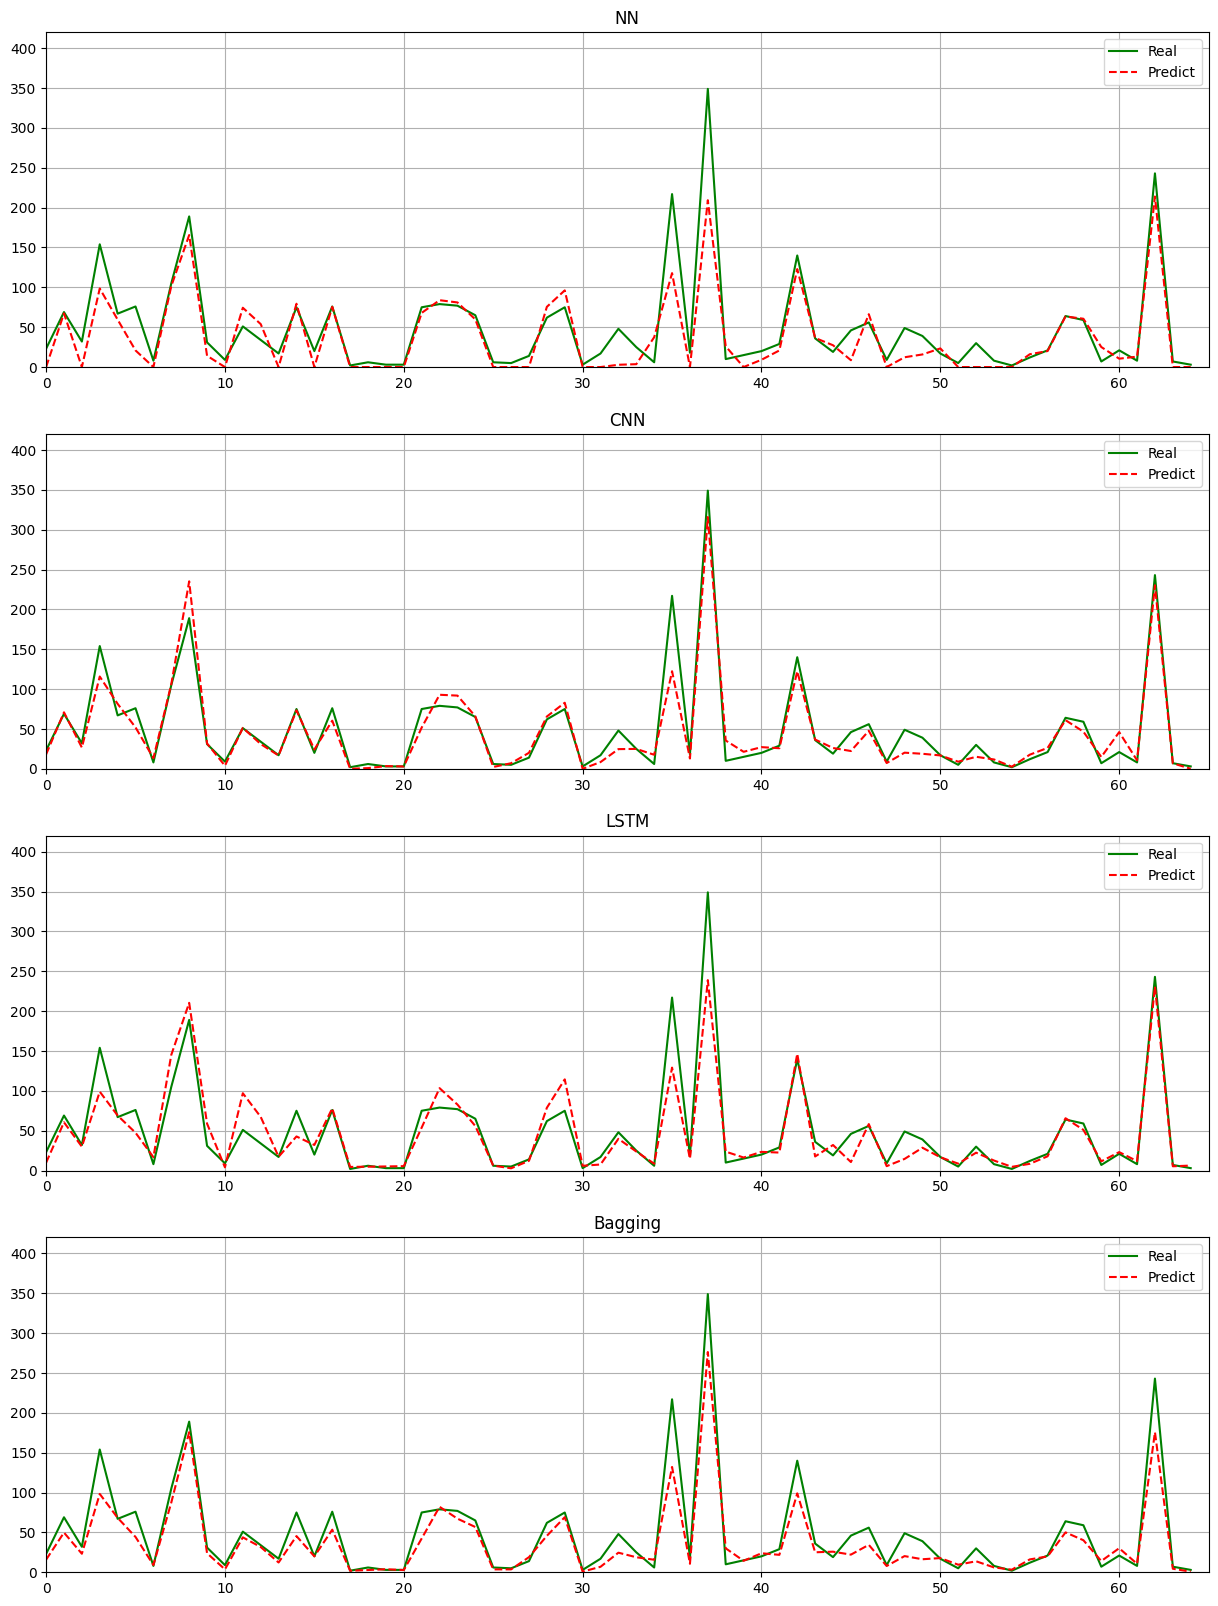

In [34]:
plot_row = 4
plot_col = 1
model = [model_nn, model_cnn, model_lstm, model_bg]
fig, axes = plt.subplots(plot_row, plot_col, figsize=(15, 20))

for row in range(plot_row):
    if row < 3:
        y_pred = model[row].predict(x_test, verbose=0)
    else:
        y_pred = GetAvgPredict_bg(model[row], num_model, x_test, 0)
    for col in range(plot_col):
        y_pred_row, y_pred_col = np.shape(y_pred)
        y_pred_row = y_pred_row*y_pred_col
        plt_idx = col+row
        axes[plt_idx].set_xlim([0, y_pred_row]) # X축의 범위
        axes[plt_idx].set_ylim([0, 420]) # Y축의 범위
        axes[plt_idx].grid()
        plt_x = np.array(range(0, y_pred_row))
        plt_y_real = np.reshape(y_test, (-1,1))
        plt_y_pred = np.reshape(y_pred, (-1,1))
        axes[plt_idx].plot(plt_x, plt_y_real, 'g-', label='Real')
        axes[plt_idx].plot(plt_x, plt_y_pred, 'r--', label='Predict')
        axes[plt_idx].legend()
    mse = mean_squared_error(plt_y_real, plt_y_pred)
    if row == 0:
        axes[plt_idx].set_title("NN")
        print("NN MSE:", mse)
    elif row == 1:
        axes[plt_idx].set_title("CNN")
        print("CNN MSE:", mse)
    elif row == 2:
        axes[plt_idx].set_title("LSTM")
        print("LSTM MSE:", mse)
    else:
        axes[plt_idx].set_title("Bagging")
        print("Boosting MSE:", mse)

In [35]:
svc = pd.read_csv("svc.csv", encoding='ms949')
cond = svc["년도"] == '2022년'
data = PreProcess(svc[cond])
x_tmp, y_tmp = GetTrainData(data.reset_index(), times, pred_day)
x_input = scaler.transform(x_tmp)
y_real = np.array(y_tmp)

NN MSE: 359.6639469972049 statistic: [0.78685959] P-value: [0.43188464]
CNN MSE: 217.22818738447612 statistic: [-0.92953975] P-value: [0.35323577]
LSTM MSE: 695.6194268931928 statistic: [-2.52719513] P-value: [0.01192765]
Bagging MSE: 192.1869686830437 statistic: [0.35756614] P-value: [0.72087873]


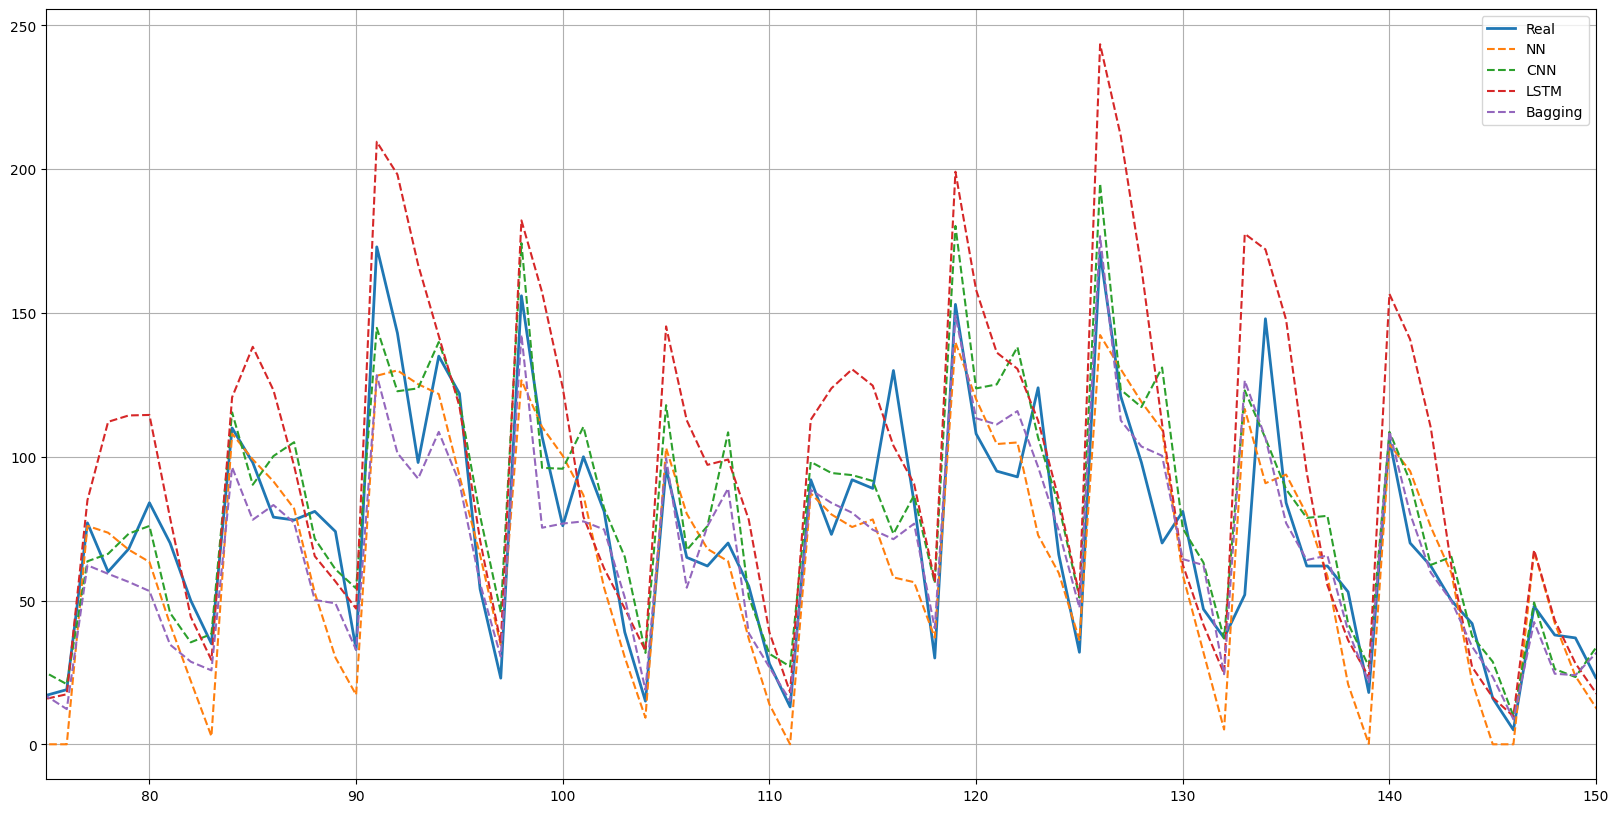

In [37]:
pred_model = 4
model = [model_nn, model_cnn, model_lstm, model_bg]

y_plt_row, y_plt_col = np.shape(y_real)
y_plt_row = y_plt_row*y_plt_col
x_plt = np.array(range(0, y_plt_row))
y_plt_real = np.reshape(y_real, (-1,1))

plt.figure(figsize=(20,10)); plt.grid()
plt.plot(x_plt, y_plt_real, '-', label='Real', linewidth=2)

y_plt_pred = np.reshape(model[0].predict(x_input, verbose=0), (-1,1))
plt.plot(x_plt, y_plt_pred, '--', label='NN')
mse = mean_squared_error(y_plt_real, y_plt_pred)
t_stat, p_value = stats.ttest_ind(y_plt_real, y_plt_pred)
print("NN MSE:", mse, "statistic:", t_stat, "P-value:", p_value)

y_plt_pred = np.reshape(model[1].predict(x_input, verbose=0), (-1,1))
plt.plot(x_plt, y_plt_pred, '--', label='CNN')
mse = mean_squared_error(y_plt_real, y_plt_pred)
t_stat, p_value = stats.ttest_ind(y_plt_real, y_plt_pred)
print("CNN MSE:", mse, "statistic:", t_stat, "P-value:", p_value)

y_plt_pred = np.reshape(model[2].predict(x_input, verbose=0), (-1,1))
plt.plot(x_plt, y_plt_pred, '--', label='LSTM')
mse = mean_squared_error(y_plt_real, y_plt_pred)
t_stat, p_value = stats.ttest_ind(y_plt_real, y_plt_pred)
print("LSTM MSE:", mse, "statistic:", t_stat, "P-value:", p_value)

y_plt_pred = np.reshape(GetAvgPredict_bg(model[3], num_model, x_input, 0), (-1,1))
plt.plot(x_plt, y_plt_pred, '--', label='Bagging')
mse = mean_squared_error(y_plt_real, y_plt_pred)
t_stat, p_value = stats.ttest_ind(y_plt_real, y_plt_pred)
print("Bagging MSE:", mse, "statistic:", t_stat, "P-value:", p_value)

plt.xlim([75,150])
plt.legend()

In [39]:
#7일 예측 모델로 생성

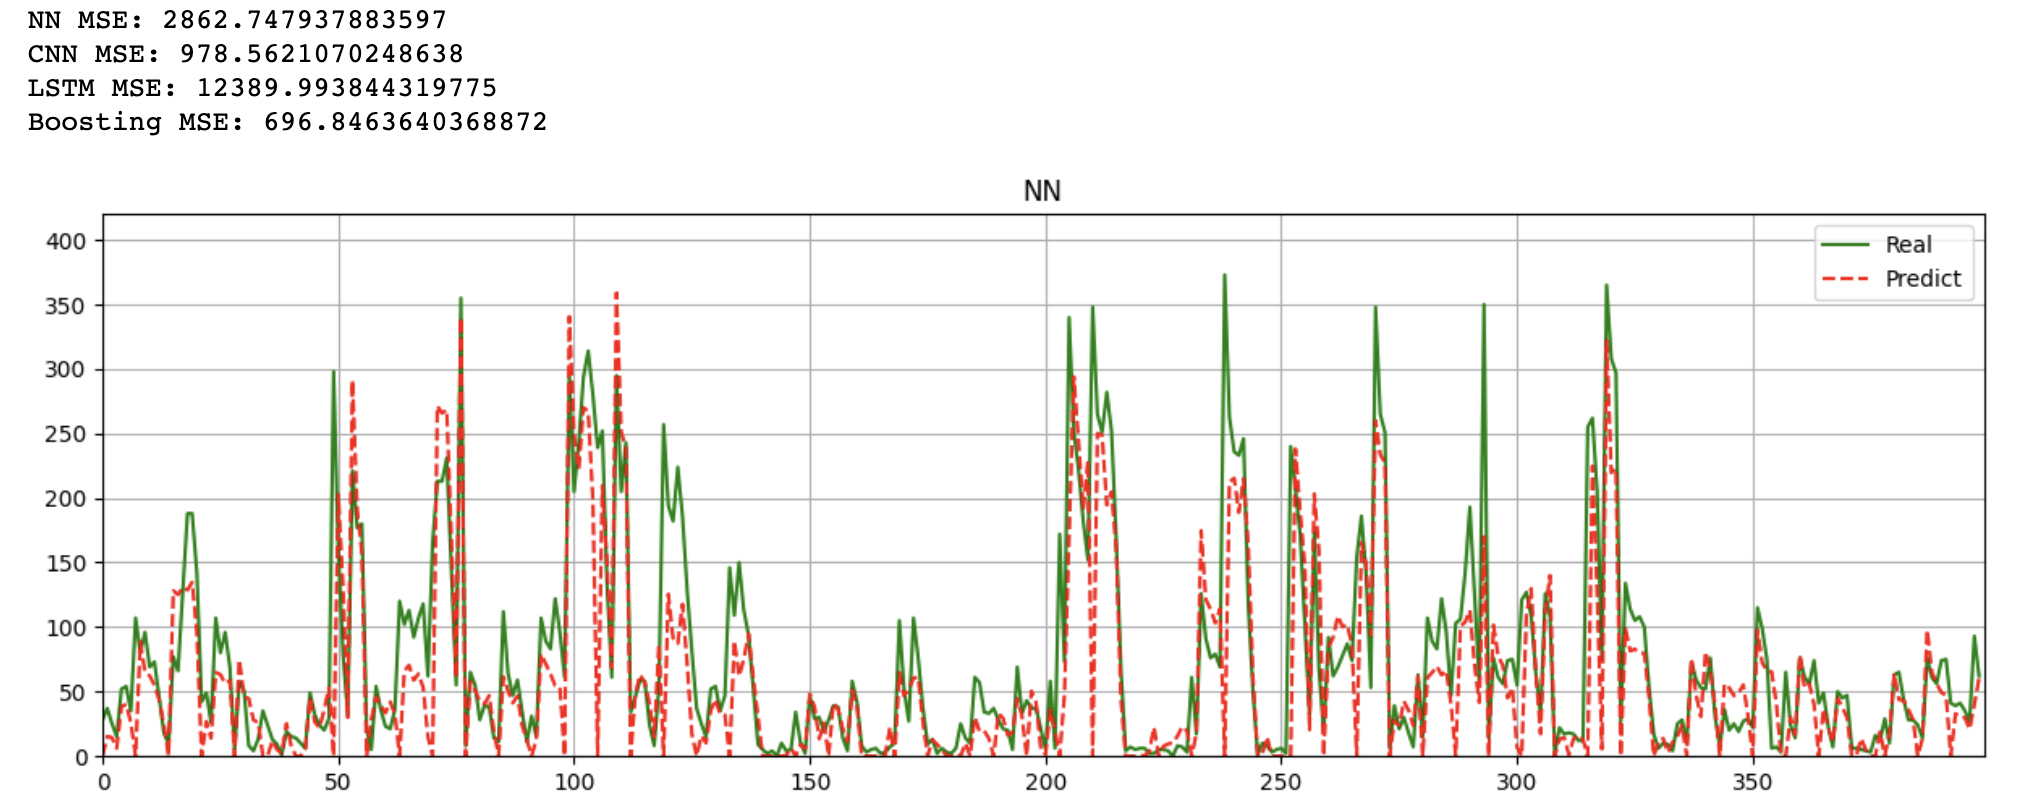
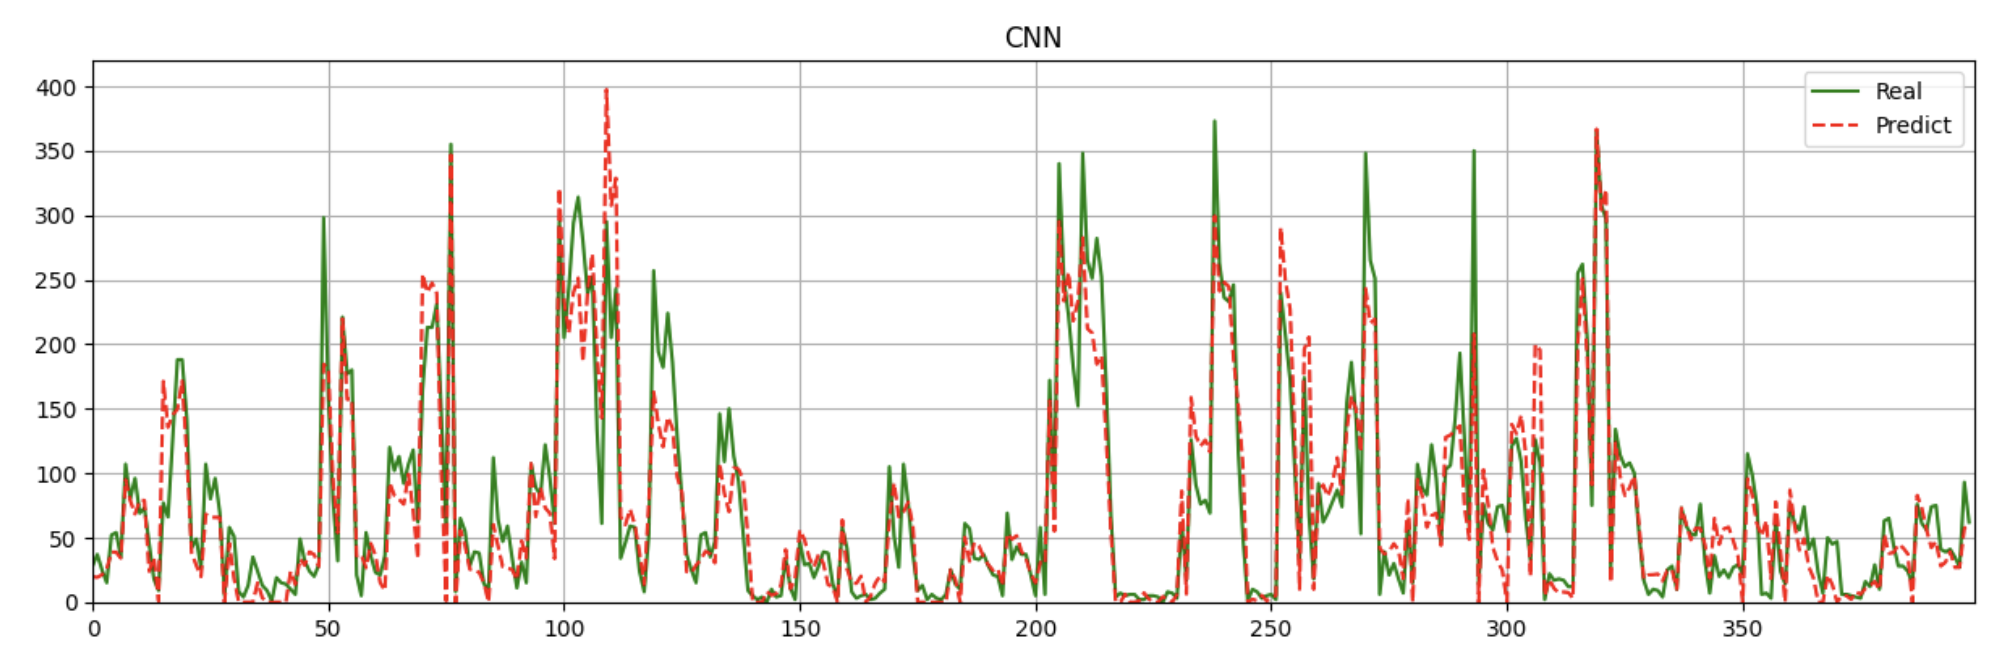
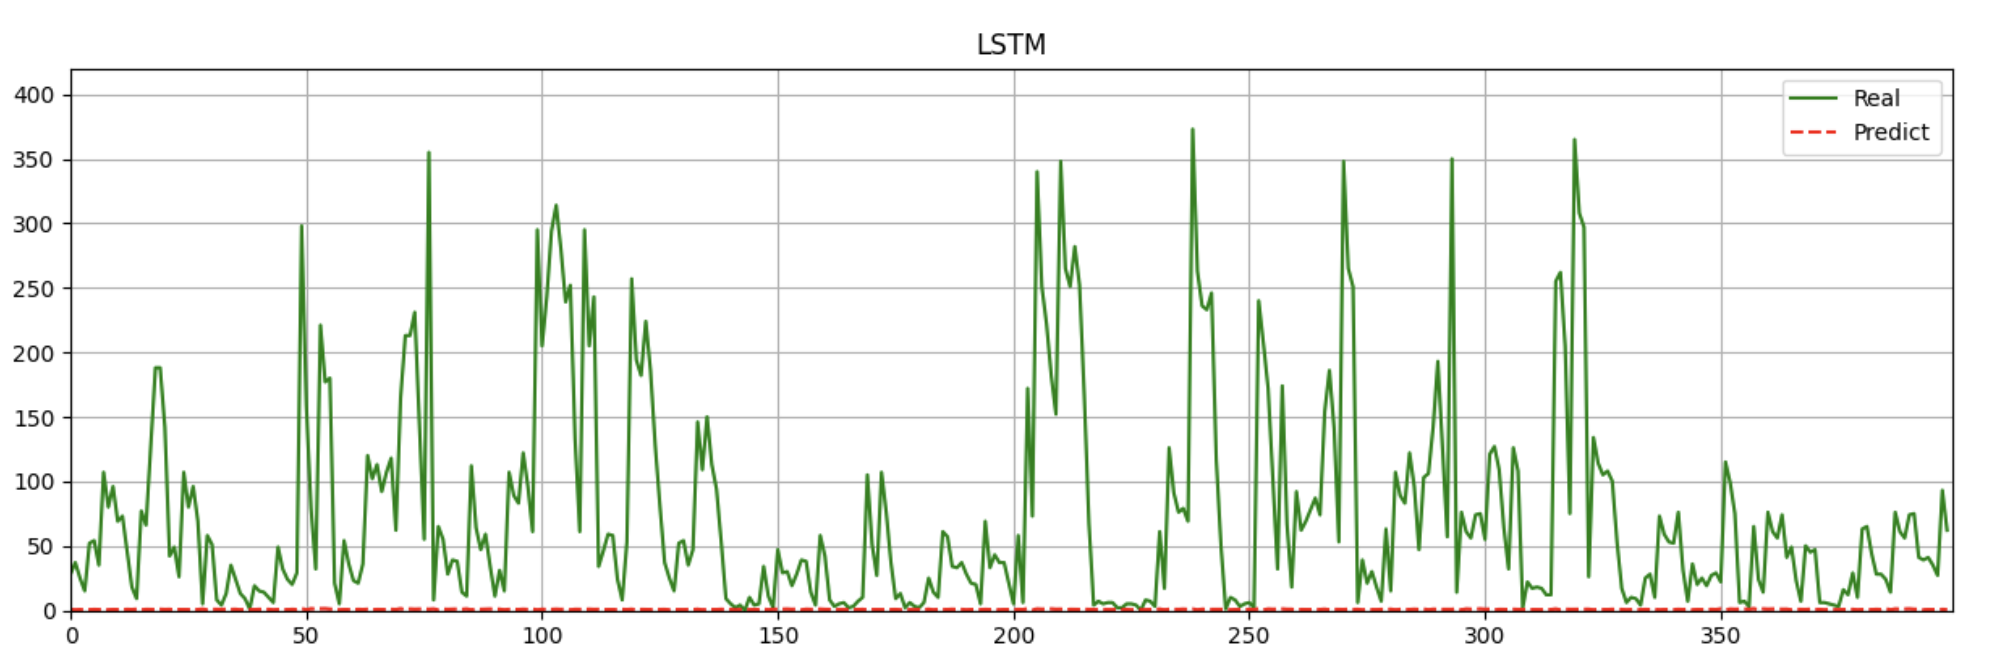
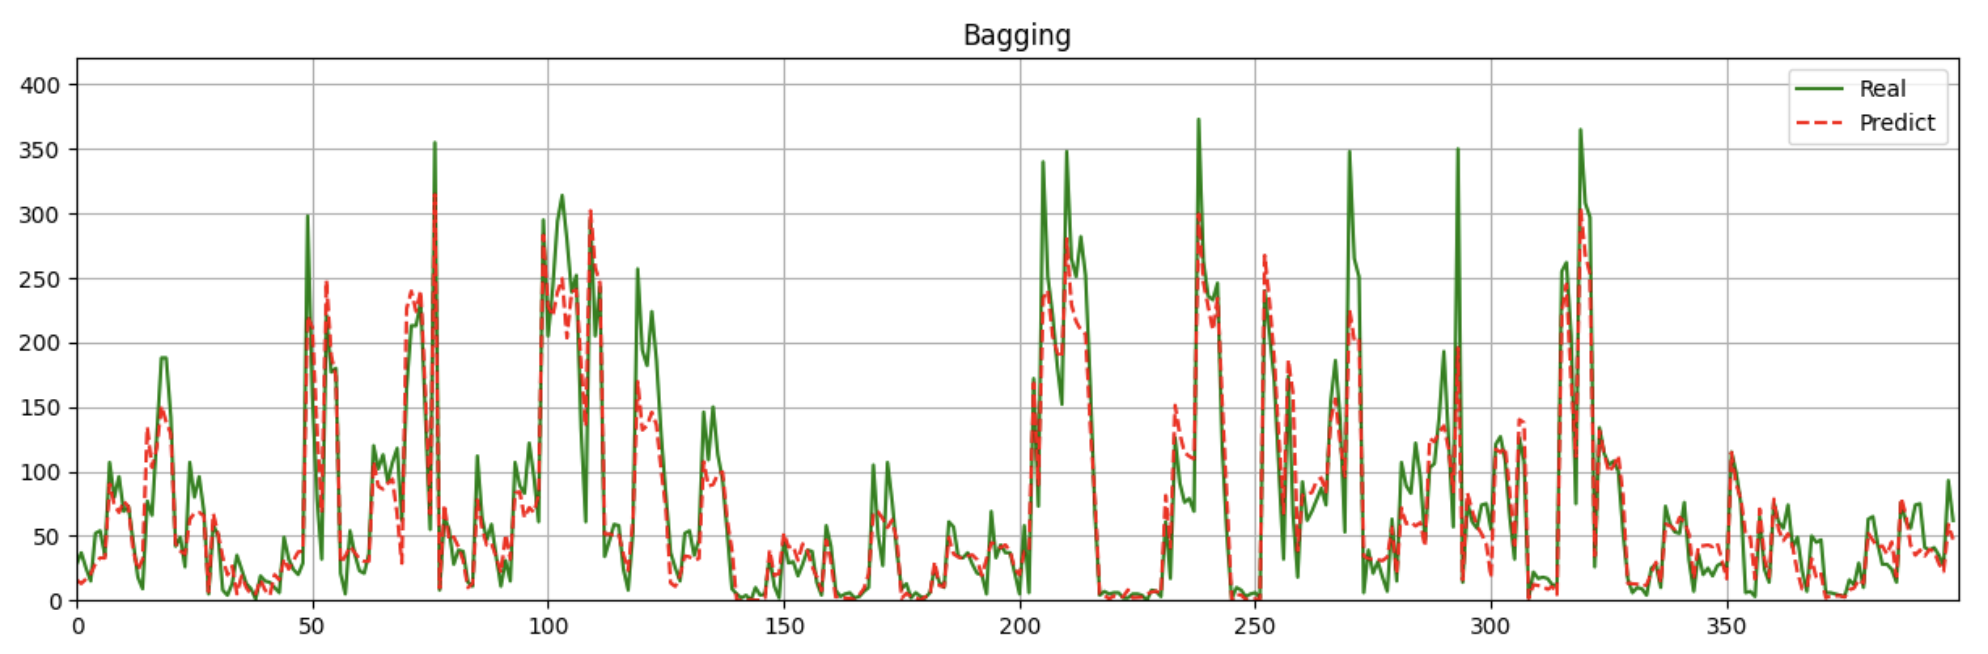
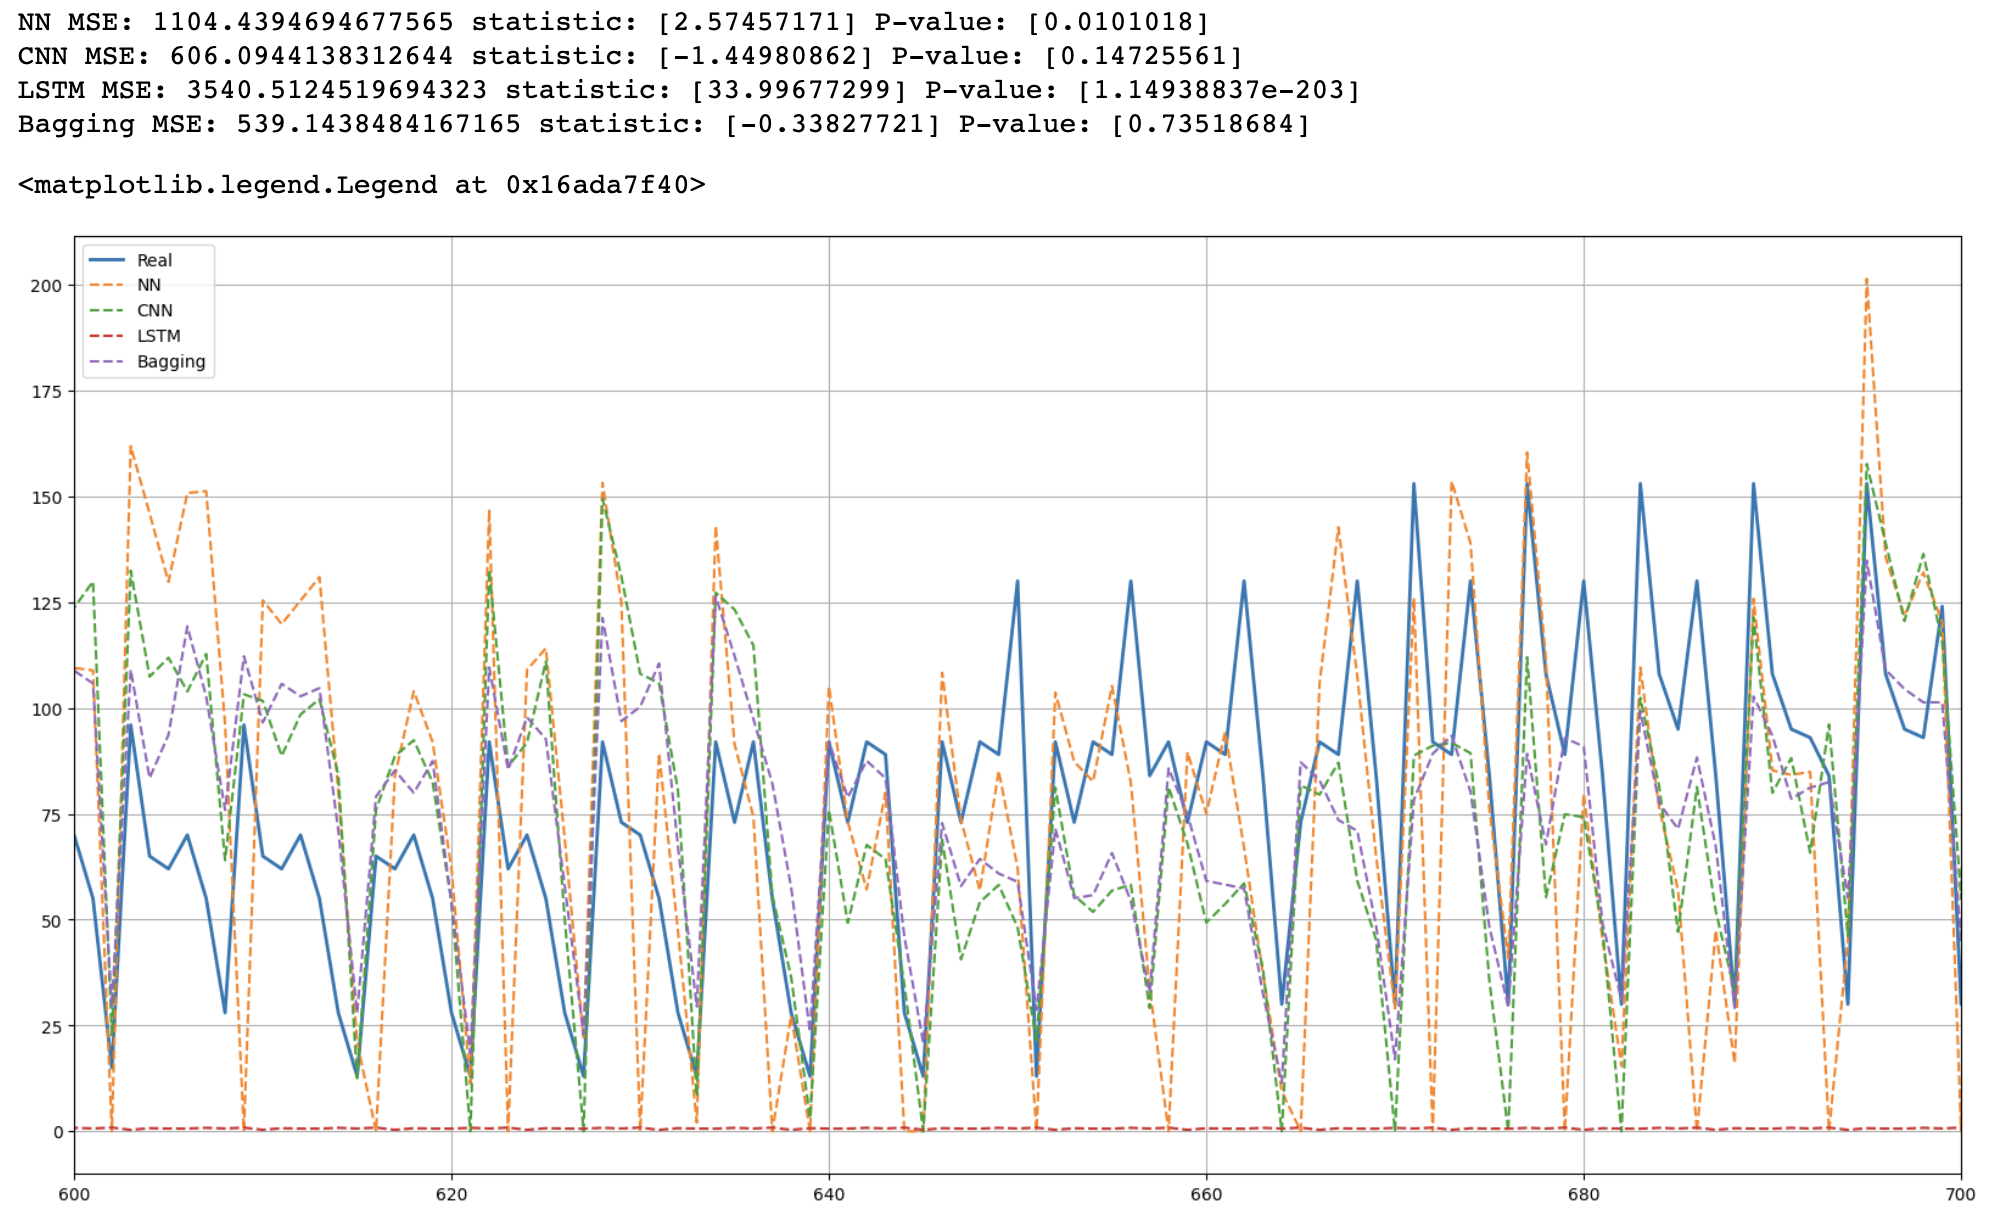

# 데이터 생성

In [40]:
svc_data = pd.read_csv("svc.csv", encoding='ms949')
svc_data = PreProcess(svc_data)

In [41]:
def GetTrainData_2d(data, nTimes, nPred=7):
    x = []
    y = []
    x_col_ol = ["평균기온", "최고기온", "Sales", "SVC 접수"]
    x_col_sg = ["날짜", "요일"]
    y_col = ["SVC 접수"]
    if nPred == 0:
        print("예측데이터 수 에러")
        return x, y
    if nTimes <= 1:
        x = np.array(data[x_col]).tolist()
        y = np.array(adata[y_col]).tolist()
    else:
        for i in range(data.shape[0]):
            if (i+nPred) > data.shape[0]:
                break
            if i < nTimes:
                continue
            else:
                x_arr_2d = np.array([])
                for idx_d in range(i,i+nPred):
                    x_arr = np.array([])
                    for x_col in x_col_ol:
                        x_arr = np.concatenate((x_arr, data[x_col][idx_d-nTimes:idx_d]))
                    x_tmp = data[x_col_sg].loc[idx_d-1]
                    x_arr = np.concatenate((x_tmp, x_arr), axis=0)
                    if x_arr_2d.size == 0:
                        x_arr_2d = np.expand_dims(x_arr, axis=0)
                    else:
                        x_arr = np.expand_dims(x_arr, axis=0)
                        x_arr_2d = np.concatenate((x_arr_2d, x_arr), axis=0)
                x.append(x_arr_2d.tolist())
                y_tmp = data["SVC 접수"][i:i+nPred]
                y.append(y_tmp.tolist())
    return x, y

In [42]:
#연도별 overlap 데이터 생성
pred_day = 7
times = 3
year = svc_data["년도"].unique()
year = year[0:-1] # 2021년까지
x_data = []
y_data = []
for i in year:
    print(i)
    cond = svc_data["년도"] == i
    x_tmp, y_tmp = GetTrainData_2d(svc_data[cond].reset_index(), times, pred_day)
    x_data = x_data+x_tmp
    y_data = y_data+y_tmp

2016년
2017년
2018년
2019년
2020년
2021년


In [43]:
for i in range(np.shape(x_data)[0]):
    x_data[i] = scaler.transform(x_data[i])
n, row, col = np.shape(x_data)
x = np.reshape(x_data, (-1,row,col,1))
y = np.array(y_data)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.3, random_state = 1)

In [45]:
x_n, x_row, x_col, x_ch = np.shape(x_train)
y_row, y_col = np.shape(y_train)
print(x_n, x_row, x_col, x_ch, y_row, y_col)

835 7 14 1 835 7


# 데이터 학습

In [46]:
#2D CNN
model_cnn_2d = Sequential()
model_cnn_2d.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(x_row,x_col,x_ch)))
model_cnn_2d.add(MaxPooling2D((2,2)))
model_cnn_2d.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_cnn_2d.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_cnn_2d.add(MaxPooling2D(2,2))
model_cnn_2d.add(Flatten())
model_cnn_2d.add(Dense(128, activation='relu'))
model_cnn_2d.add(Dense(y_col, activation='relu'))
model_cnn_2d.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 14, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 7, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 7, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 3, 64)          0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 192)              

In [47]:
if load_model_cnn_2d == True:
    model_cnn_2d.load_weights('svc_model_cnn_2d.h5')
else:
    model_cnn_2d.compile(loss='mse', optimizer='adam', metrics=['mse'])
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
    history = model_cnn_2d.fit(x_train, y_train, 
        epochs=2000, 
        batch_size=32, 
        callbacks=[early_stopping], 
        validation_data=(x_val, y_val), 
        verbose=2)
    if early_stopping.stopped_epoch > 0:
        stopped_loss = history.history['loss'][early_stopping.stopped_epoch - 1]
        print("Early stopping stopped at epoch", early_stopping.stopped_epoch, "with loss", stopped_loss)

In [48]:
if load_model_cnn_2d == False:
    model_cnn_2d.save_weights('svc_model_cnn_2d.h5')

In [49]:
y_pred = model_cnn_2d.predict(x_test)

2/2 [==============================] - 0s 2ms/step


2D CNN MSE: 236.33371715993803


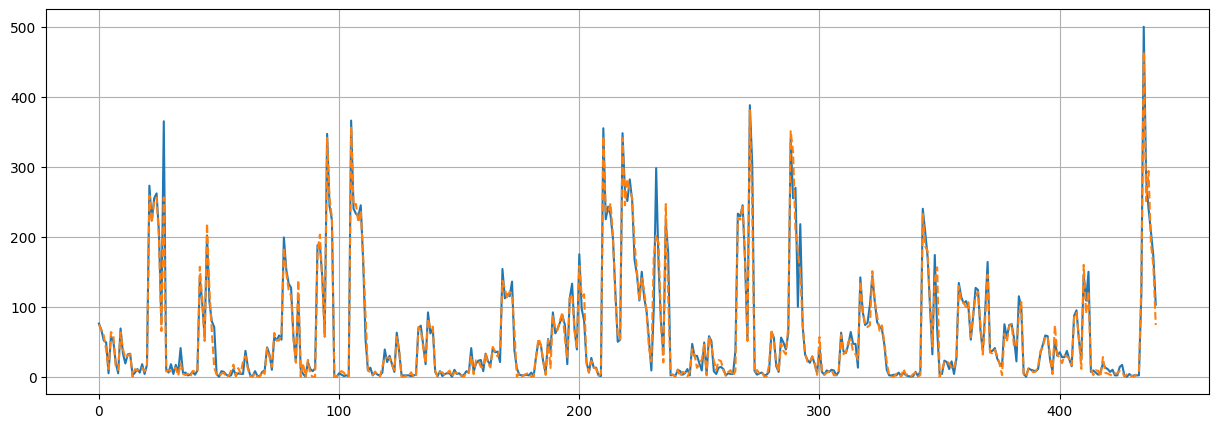

In [50]:
y_pred_row, y_pred_col = np.shape(y_pred)
y_pred_row = y_pred_row*y_pred_col
plt_x = np.array(range(0, y_pred_row))
plt_y_real = np.reshape(y_test, (-1,1))
plt_y_pred = np.reshape(y_pred, (-1,1))
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(plt_x, plt_y_real,'-')
plt.plot(plt_x, plt_y_pred,'--')
mse = mean_squared_error(plt_y_real, plt_y_pred)
print("2D CNN MSE:", mse)

In [51]:
svc = pd.read_csv("svc.csv", encoding='ms949')
cond = svc["년도"] == '2022년'
data = PreProcess(svc[cond])
x_tmp, y_tmp = GetTrainData_2d(data.reset_index(), times, pred_day)
for i in range(np.shape(x_tmp)[0]):
    x_tmp[i] = scaler.transform(x_tmp[i])
n, row, col = np.shape(x_tmp)
x_input = np.reshape(x_tmp, (-1,row,col,1))
y_real = np.array(y_tmp)

6/6 [==============================] - 0s 2ms/step
2D CNN MSE: 91.43972373453039


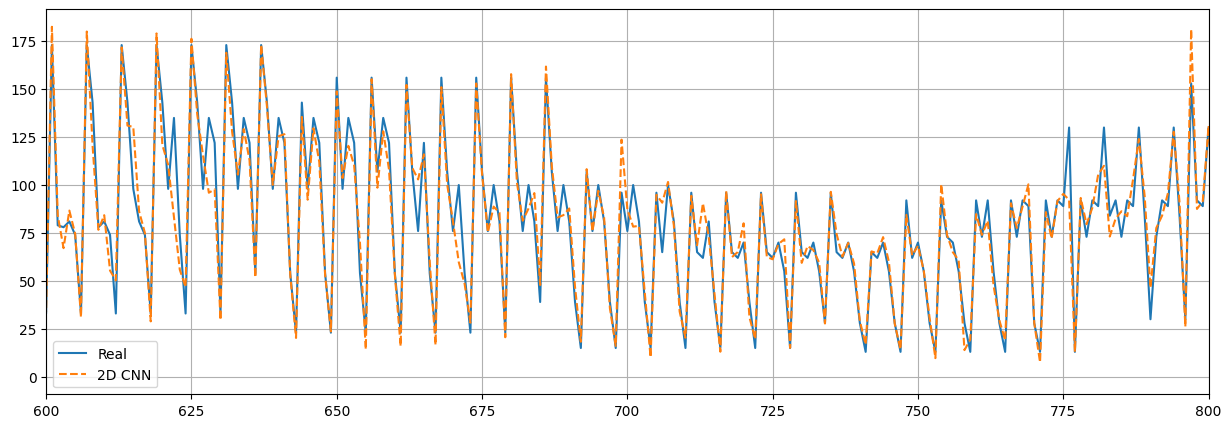

In [54]:
y_pred = model_cnn_2d.predict(x_input)
y_pred_row, y_pred_col = np.shape(y_pred)
y_pred_row = y_pred_row*y_pred_col
plt_x = np.array(range(0, y_pred_row))
plt_y_real = np.reshape(y_real, (-1,1))
plt_y_pred = np.reshape(y_pred, (-1,1))
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(plt_x, plt_y_real,'-',label='Real')
plt.plot(plt_x, plt_y_pred,'--', label='2D CNN')
plt.xlim([600,800])
plt.legend()
mse = mean_squared_error(plt_y_real, plt_y_pred)
print("2D CNN MSE:", mse)